# Cassava Leaf Disease Classification

This notebook builds and trains a model for cassava leaf disease classification for the [Kaggle competition](https://www.kaggle.com/c/cassava-leaf-disease-classification/overview).

## Experiment results

1. Cross entropy loss, stratified CV, no fmix, cutmix, mixup, w gradient scaling & accumulation
2. Add smoothed cross entropy loss
3. Add *mixes
4. external data



In [1]:
package_paths = [
    # this is a project by Ross Wightman (https://github.com/rwightman/pytorch-image-models)
    '../pytorch-image-models'
]
import sys; 

for pth in package_paths:
    sys.path.append(pth)

In [2]:
import os
from datetime import datetime
import time
import random
import warnings
import joblib
import warnings

from config import Config # my configurations file with hyperparams and constants
from logger import init_logger

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2

import sklearn
from sklearn.model_selection import StratifiedKFold
from skimage import io
from scipy.ndimage.interpolation import zoom
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score


import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

import timm # pytorch-image-models implementations

## Preliminary data loading and setup

In [3]:
train = pd.read_csv(Config.data_csv, engine='python')

if Config.debug:
    train = train.sample(n=1000, random_state=Config.seed).reset_index(drop=True)
    Config.epochs = 1
    
train.head()

,image_id,label
0,1668363819.jpg,2
1,3356448488.jpg,3
2,262606974.jpg,1
3,3511031067.jpg,3
4,1278537815.jpg,1


In [4]:
label_map = pd.read_json(Config.data_dir + '/label_num_to_disease_map.json', orient='index')
label_map

,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


Since the distribution of classes is uneven, we could do stratified k-fold cross validation to make each fold's train and validation distributions representative of the original distributions.

In [5]:
train.label.value_counts()

3    632
1    123
4    103
2    103
0     39
Name: label, dtype: int64

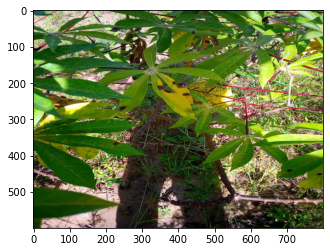

In [6]:
def set_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

    
def get_image(path):
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    # im_rgb = im_bgr[:, :, ::-1] would also work -> select all x, y, and reverse the color channels
    return img_rgb

set_seeds(Config.seed)
LOGGER = init_logger() # uses Python's logging framework

sample_img = get_image(Config.train_img_dir + '/1000015157.jpg')
plt.imshow(sample_img)
plt.show()

## Dataset class

Todo ideas: add cutmix, fmix, mixup


In [7]:
class CassavaDataset(Dataset):
    def __init__(self, df, data_root_dir, transform=None, output_label=False):
        self.df = df.reset_index(drop=True).copy()
        self.data_root_dir = data_root_dir
        self.transform = transform
        self.output_label = output_label
        self.labels = self.df.label.values
 
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = get_image('{}/{}'.format(self.data_root_dir, self.df.image_id[idx]))
        
        if self.transform:
             img = self.transform(image=img)['image']
                
        if self.output_label == True:
            return img, self.labels[idx]
        else:
            return img

#### Test it out

0 (600, 800, 3) 2
1 (600, 800, 3) 3


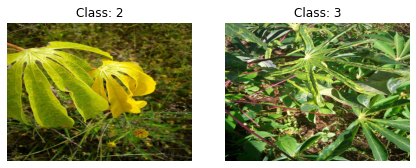

In [8]:
cassava_dataset = CassavaDataset(train, Config.train_img_dir, output_label=True)
fig = plt.figure()
for i in range(2):
    img, target = cassava_dataset[i]
    print(i, img.shape, target)
    
    ax = plt.subplot(1, 2, i + 1)
    plt.tight_layout()
    ax.set_title('Class: {}'.format(target))
    ax.axis('off')
    plt.imshow(img)
    if i == 3:
        plt.show()
        break

## Stratified Cross Validation Folds

In [9]:
train_folds = train.copy()
stratifiedFold = StratifiedKFold(n_splits=Config.fold_num, shuffle=True, random_state=Config.seed)
splits = stratifiedFold.split(np.zeros(len(train_folds)), train_folds[Config.target_col])

# label all rows of train_folds with a particular validation set fold number they are part of 
# (to select the row for validation when splitting on that fold)
for fold_num, (train_idxs, val_idxs) in enumerate(splits):
    train_folds.loc[val_idxs, 'fold'] = fold_num

train_folds['fold'] = train_folds['fold'].astype(int)
train_folds.head()

,image_id,label,fold
0,1668363819.jpg,2,2
1,3356448488.jpg,3,3
2,262606974.jpg,1,1
3,3511031067.jpg,3,0
4,1278537815.jpg,1,1


In [10]:
# verify distributions
train_folds.groupby(['fold', 'label']).count()

image_id
fold label          
0    0             7
     1            25
     2            21
     3           126
     4            21
1    0             8
     1            25
     2            21
     3           126
     4            20
2    0             8
     1            25
     2            21
     3           126
     4            20
3    0             8
     1            24
     2            20
     3           127
     4            21
4    0             8
     1            24
     2            20
     3           127
     4            21

## Define Train\Validation Image Augmentations

In [11]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    image_size = Config.img_size
    return Compose([
            RandomResizedCrop(image_size, image_size),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    image_size = Config.img_size
    return Compose([
            CenterCrop(image_size, image_size, p=1.),
            Resize(image_size, image_size),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

## Model

EfficientNet noisy student: https://arxiv.org/pdf/1911.04252.pdf. Implementation from
https://github.com/rwightman/pytorch-image-models.

In [12]:
class Model(torch.nn.Module):
    def __init__(self, model_arch, n_classes, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        # replace classifier with a Linear in_features->n_classes layer
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, n_classes)
        
    def forward(self, x):
        return self.model(x)

## Loss function 

Ideas:
- https://ai.googleblog.com/2019/08/bi-tempered-logistic-loss-for-training.html
- https://github.com/mlpanda/bi-tempered-loss-pytorch/blob/master/bi_tempered_loss.py
- https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733

In [13]:
# reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
class SmoothedCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [14]:
class BiTemperedLoss():
    def __init__(self):
        pass
    
    def forward(self, inputs, targets):
        pass

## Training and Validation Functions

gradient scaling https://pytorch.org/docs/stable/notes/amp_examples.html

gradient accumulation https://towardsdatascience.com/what-is-gradient-accumulation-in-deep-learning-ec034122cfa

https://towardsdatascience.com/deep-learning-model-training-loop-e41055a24b73

In [15]:
# loops over data with gradient scaling and accumulation
def train_epoch(dataloader, model, criterion, optimizer, scheduler, scaler):
    model.train()
    batch_losses = []
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        with autocast():
            predictions = model(images)
            loss = criterion(predictions, labels)
        
        batch_losses.append(loss.item())

        # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
        # Backward passes under autocast are not recommended.
        # Backward ops run in the same dtype autocast chose for corresponding forward ops.
        # See https://pytorch.org/docs/stable/amp.html#gradient-scaling for why scaling is helpful
        scaler.scale(loss).backward()

        to_print = batch_idx + 1 % Config.print_every == 0
        # TEMPORARY
        total_norm = 0.
        if to_print or batch_idx + 1 == len(dataloader):
           # get gradients to check for explosions and determine clipping value
            for p in list(filter(lambda p: p.grad is not None, model.parameters())):
                param_norm = p.grad.data.norm(2).item() # norm of the gradient tensor
                LOGGER.info(f'parameter grad shape {p.grad.size()}')
                total_norm += param_norm ** 2
            total_norm = total_norm ** (1./2) 

        if batch_idx + 1 % Config.accum_iter == 0 or batch_idx + 1 == len(dataloader):
            # if want to implement gradient clipping, see this first. need to unscale gradients first.
            # https://pytorch.org/docs/stable/notes/amp_examples.html#working-with-unscaled-gradients
        
            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
            # otherwise, optimizer.step() is skipped.
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()
            optimizer.zero_grad()
                
        if to_print or batch_idx + 1 == len(dataloader):
            LOGGER.info(f'batch {batch_idx+1}/{len(dataloader)} loss: {loss} | grad: {total_norm}')

    return batch_losses

def valid_epoch(dataloader, model, criterion):
    model.eval()
    batch_losses = []
    predictions = []

    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            output = model(images)
        
        loss = criterion(output, labels)
        
        batch_losses.append(loss)
        predictions.append(torch.argmax(output, 1).detach().cpu().numpy())
        
        if batch_idx + 1 % Config.print_every == 0 or batch_idx + 1 == len(dataloader):
            LOGGER.info(f'[VAL] batch {batch_idx+1}/{len(dataloader)} loss: {loss / Config.accum_iter}')
    
    all_predictions = np.concatenate(predictions)
    return batch_losses, all_predictions
    
'''
    Trains the model over epochs for a given fold
    
    train_folds_df: the dataset with a column for fold number
    fold: an integer representing the fold used for validation
    
    Returns a DataFrame consisting of only the the rows used for validation along with the model's predictions
''' 
def train_fold(train_folds_df, fold, model, optimizer, scheduler, best_accuracy):
    # -------- DATASETS AND LOADERS --------
    train_idx = train_folds_df[train_folds_df['fold'] != fold].index  
    valid_idx = train_folds_df[train_folds_df['fold'] == fold].index 
    train_df = train_folds_df.iloc[train_idx].reset_index(drop=True) # since we are selecting rows, the index will be missing #s so reset
    valid_df = train_folds_df.iloc[valid_idx].reset_index(drop=True)
    
    train_dataset = CassavaDataset(train_df, Config.train_img_dir, output_label=True, transform=get_train_transforms())
    valid_dataset = CassavaDataset(valid_df, Config.train_img_dir, output_label=True, transform=get_valid_transforms())
    
    train_dataloader = DataLoader(train_dataset, batch_size=Config.train_bs, 
                                  pin_memory=True, shuffle=True, 
                                  num_workers=Config.num_workers)
    valid_dataloader = DataLoader(valid_dataset, batch_size=Config.valid_bs, 
                                  pin_memory=True, shuffle=False, 
                                  num_workers=Config.num_workers)
    
    
    # -------- LOSS FUNCTION --------
    criterion = nn.CrossEntropyLoss()
    
    for e in range(Config.epochs):
        epoch_start_time = time.time()
        LOGGER.info(f'Training epoch {e+1}/{Config.epochs}')
        
        # -------- TRAIN --------
        training_losses = train_epoch(train_dataloader, model, criterion, optimizer, scheduler, GradScaler())
        avg_training_loss = sum(training_losses) / len(train_dataloader)
        
        # -------- VALIDATE --------
        validation_losses, preds = valid_epoch(valid_dataloader, model, criterion)
        avg_validation_loss = sum(validation_losses) / len(valid_dataloader)
        
        epoch_elapsed_time = time.time() - epoch_start_time

        # -------- SCORE METRICS & LOGGING FOR THIS EPOCH --------
        validation_labels = valid_df[Config.target_col].values
        accuracy = accuracy_score(y_true=validation_labels, y_pred=preds)
        
        LOGGER.info(f'Epoch training summary. Fold {fold}/{Config.fold_num} | ' + \
                    f'Epoch: {e+1}/{Config.epochs} | ' + \
                    f'Epoch time: {epoch_elapsed_time} | ' + \
                    f'Training loss: {avg_training_loss} | ' + \
                    f'Validation loss: {avg_validation_loss} | ' + \
                    f'Accuracy: {accuracy}')
        
        if accuracy > best_accuracy: # SAVE MODEL
            best_accuracy = accuracy
            torch.save({'model': model.state_dict(), 'preds': predictions},
                      Config.save_dir + f'{Config.model_name}_fold{fold}.pth')
            LOGGER.info(f'Saved model on epoch {e+1} with accuracy score {accuracy:.3f}')
        
        # -------- UPDATE LR (POTENTIALLY) --------
        if scheduler:
            if Config.scheduler == 'ReduceLROnPlateau':
                scheduler.step(avg_validation_loss)
            elif Config.scheduler == 'CosineAnnealingLR' or Config.scheduler == 'CosineAnnealingWarmRestarts':
                scheduler.step()

    checkpoint = torch.load(Config.save_dir + f'{Config.model_name}_fold{fold}.pth')
    valid_folds['prediction'] = checkpoint['preds'].argmax(axis=1) # take max of each row in preds (preds: rows of probabilities for each label)
    return valid_folds

## Main loop

In [16]:
def get_result(result_df):
    preds = result_df['preds'].values
    labels = result_df[Config.target_col].values
    score = accuracy_score(y_true=labels, y_pred=preds)
    LOGGER.info(f'Score: {score:<.5f}')

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#print(device)
def main():    
    try:
        # -------- SCORES --------
        best_accuracy = 0.

         # -------- MODEL INSTANTIATION --------
        model = Model(Config.model_arch, train.label.nunique(), pretrained=True).to(device)

        # -------- OPTIMIZER --------
        optimizer = Adam(model.parameters(), Config.lr, weight_decay=Config.weight_decay, amsgrad=Config.is_amsgrad) # try amsgrad?

        # -------- SCHEDULER --------
        scheduler = None
        if Config.scheduler == 'ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, factor=Config.factor, patience=Config.patience, eps=Config.eps, verbose=True)
        elif Config.scheduler == 'CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=Config.min_lr, verbose=True)
        elif Config.scheduler == 'CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=Config.T_0, T_mult=Config.T_mult, eta_min=Config.min_lr, verbose=True)

        if Config.train:
            aggregated_output_df = pd.DataFrame()

            for fold in range(Config.fold_num):
                _df = train_fold(train_folds, fold, model, optimizer, scheduler, best_accuracy)
                print(f"train_fold() output df shape: {_df.shape}")
                aggregated_output_df = pd.concat([aggregated_output_df, _df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(aggregated_output_df)

            # Cross validation
            LOGGER.info(f"========== CV ==========")
            get_result(aggregated_output_df)
            # Save result
            aggregated_output_df.to_csv(Config.save_dir + 'aggregated_output_df.csv', index=False)

        if Config.inference:
            pass
    except RuntimeError: 
        del model
        torch.cuda.empty_cache()
    del model
    torch.cuda.empty_cache()

In [ ]:
if __name__ == '__main__':
    try:
        main()
    except KeyboardInterrupt:
        pass

Training epoch 1/1


Epoch     0: adjusting learning rate of group 0 to 1.0000e-04.


batch 50/50 loss: 1.5751128196716309 | grad: 0.0
